# EDA

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

from IPython.display import display

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
pd.set_option('display.width', 15000)
pd.set_option('display.max_columns', 100)
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_context('poster')
%matplotlib inline

In [2]:
# Load data

city = 'Full'
fig_dir = 'figs/modeling/{}/'.format(city)
data_dir = 'data/{}/'.format(city)

dfb = pd.read_pickle(data_dir + 'business.pkl')
dfr = pd.read_pickle(data_dir + 'review.pkl')
dfu = pd.read_pickle(data_dir + 'user.pkl')
datar = pd.read_pickle(data_dir + 'data_review.pkl')


# print("business table")
# print(dfb.shape)
# display(dfb.head())
# print("review table")
# print(dfr.shape)
# display(dfr.head())
# print("user table")
# print(dfu.shape)
# display(dfu.head())
# print("data_review table")
# print(datar.shape)
# display(datar.head())

In [3]:
def plot_discrete_hist(x, xticks=None, normalize=False, minlength=5, **args):
    '''
    INPUTS
    ======
    x: numpy array of shape (n,), required
    xticks: array_like, optional
        list/array to specify the order of xticks
    normalize: bool, optional
    minlength: int, optional
        minimum number of bins
    **args: 
        arguments passed to plt.bar()    
    '''
    if xticks is None:
        xticks = np.sort(np.unique(x))
        xmin = np.min(xticks)
        x = x - xmin
    else:
        if set(xticks) != set(np.unique(x)):
            raise ValueError('xticks not consistent with values in x.')
        xticks2id = {_x:i for i, _x in enumerate(xticks)}
        x = np.array([xticks2id[_x] for _x in x])
    
    counts = np.bincount(x, minlength=minlength)
       
    if normalize:
        counts = counts / np.sum(counts)        
    
    plt.bar(np.arange(len(counts)), counts, **args)
    plt.xticks(np.arange(len(xticks)), xticks) # xticks could be set manually later.

## Exploration of Review Table

We first look at the review table with size (4166778, 9). The histogram below shows the distribution of stars from total reviews in yelp. 5-star reviews takes a great proportion.

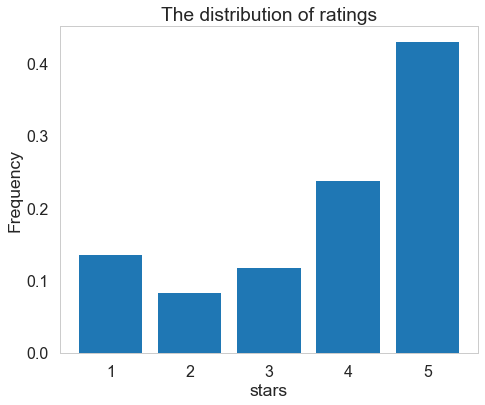

In [4]:
# Example
plt.figure(figsize=(7.5, 6))

plot_discrete_hist(dfr['stars'].values, normalize=True);
plt.xlabel('stars');
plt.ylabel('Frequency');
plt.title('The distribution of ratings');
plt.savefig(fig_dir + 'hist.png', bbox_inches='tight')

We manipulate the date column to show the relationships between review scores and year / month / day.

In [5]:
# explore review table (dfr)

## date : year, month, day

dfr['year'] = dfr['date'].apply(lambda x: int(x[:4]))
dfr['month'] = dfr['date'].apply(lambda x: int(x[5:7]))
dfr['day'] = dfr['date'].apply(lambda x: int(x[8:10]))
# dfr.head()

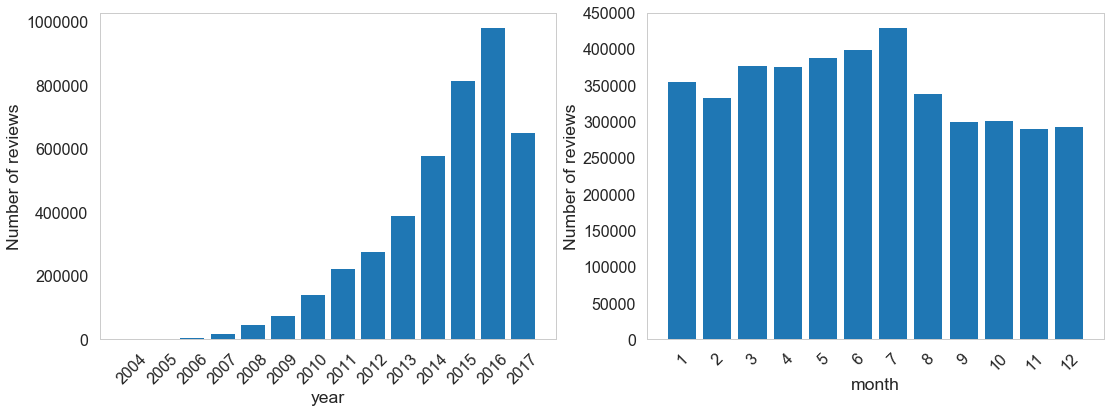

In [6]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plot_discrete_hist(dfr['year'].astype(int).values, normalize=False)
plt.xlabel('year');
plt.ylabel('Number of reviews');
plt.xticks(rotation=45);

plt.subplot(1, 2, 2)
plot_discrete_hist(dfr['month'].astype(int).values, normalize=False)
plt.xlabel('month');
plt.ylabel('Number of reviews');
plt.xticks(rotation=45);

The amount of reviews is increasing since yelp started (2017 is lower because there is not enough data). Similarly reviews received in the later months are a little bit fewer. The following is the relationships between reviews and date (month/day/year). 

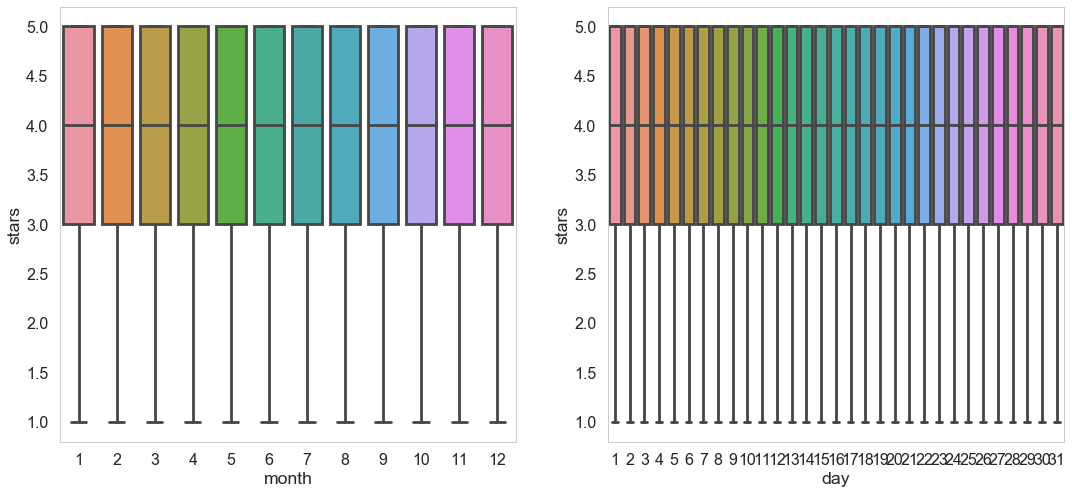

In [7]:
plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
sns.boxplot(x='month', y='stars', data=dfr);
plt.subplot(1, 2, 2)
sns.boxplot(x='day', y='stars', data=dfr);

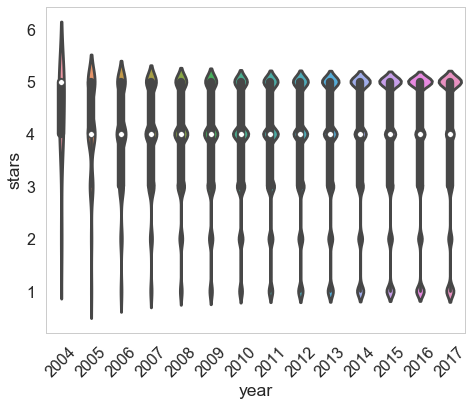

In [8]:
plt.figure(figsize=(7.5, 6))
plt.subplot(1, 1, 1)
sns.violinplot(x='year', y='stars', data=dfr);
plt.xticks(rotation=45);

There is no apparent pattern for stars w.r.t. month and day. For year as variable, at the beginning (2004/2005) most of the reviewes received high stars. However, the distribution becomes spread and polarization is severe. That means users may tend to give extreme reviews.

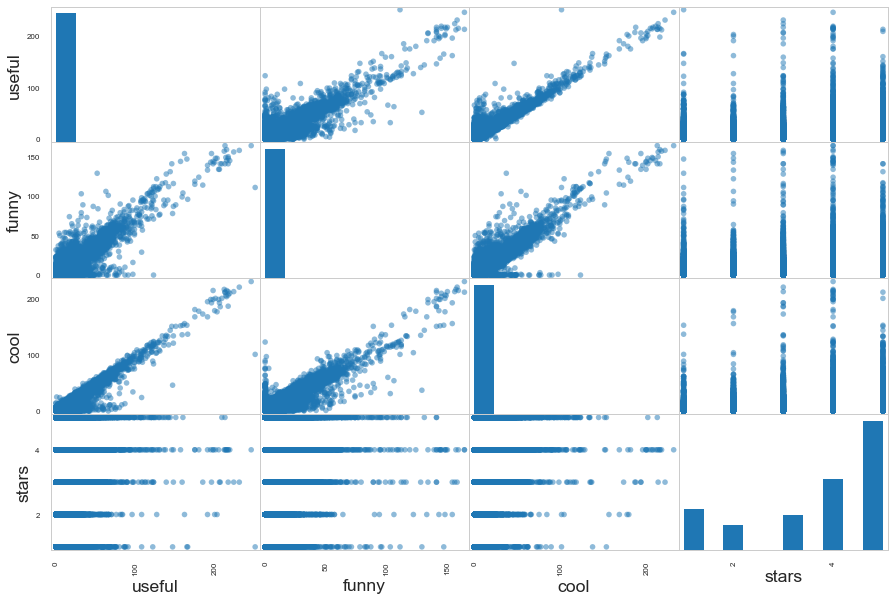

In [9]:
from pandas.plotting import scatter_matrix
fig, ax = plt.subplots(1,1, figsize=(15,10))
axes = scatter_matrix(dfr[['useful', 'funny', 'cool', 'stars']], alpha=0.5, diagonal='hist', ax=ax)
plt.show()

This is the correlation graph for stars of each review and three attributes received by this review. There are some interesting facts:

1. distribution of stars w.r.t. useful: reviews given by low stars are more likely to be agreed as 'useful' by other users.

2. useful, cool and funny has certain positive relationships. Perhaps yelp would rank this review at top by default so they are much easier to be commented by users.


## Exploration of Business Table

In [10]:
## inner join business (dfb) & stars (datar)
## p.s. stars_x represent star given by single user
##      stars_y represent average stars of restaurant

df_br = datar.merge(dfb, left_on="business_id", right_on="business_id")
#df_br.head()

We explore the restaurants information by merging business talbe with data_review table. We get a table with size (4166778, 95). Here stars_x represent star given by single user and stars_y represent average stars of restaurant. We first have a glance at the distribution of restaurants' average stars (star_y) and wordcloud for 1-star and 5-star review.

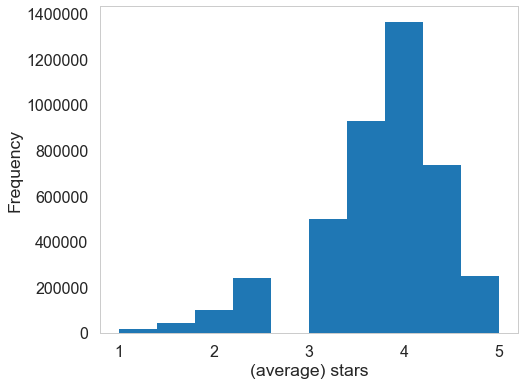

In [11]:
plt.figure(figsize=(7.5, 6))

plt.hist(df_br['stars_y'].values);
plt.xlabel('(average) stars');
plt.ylabel('Frequency');

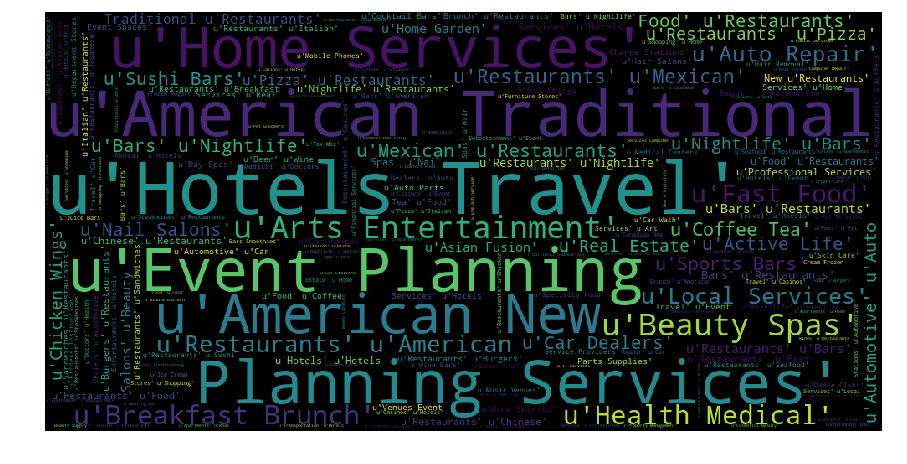

In [12]:
from wordcloud import WordCloud
wordcloud = WordCloud(width = 1000, height = 500).generate(' '.join(df_br[df_br['stars_x'] == 1]['categories']));
plt.figure(figsize=(15,8));
plt.imshow(wordcloud);
plt.axis('off');

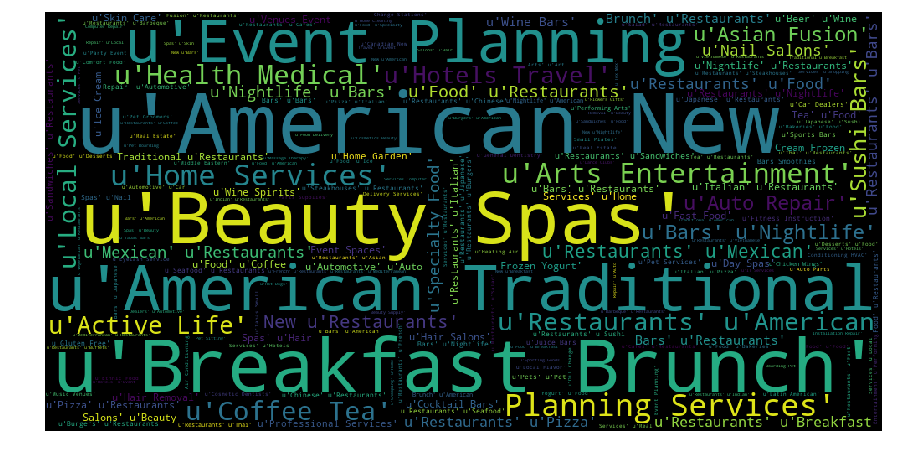

In [13]:
from wordcloud import WordCloud
wordcloud = WordCloud(width = 1000, height = 500).generate(' '.join(df_br[df_br['stars_x'] == 5]['categories']));
plt.figure(figsize=(15,8));
plt.imshow(wordcloud);
plt.axis('off');

Comparing the categories between 1-star and 5-star reviews, we found that they differ with each other to some extent. For example, american traditional appear more in 1-star review, while American new appear more in 5-star. 

In [14]:
# df_br['postal_code'] = df_br['postal_code'].apply(lambda x: x[1:])

In [15]:
df_br2 = df_br.dropna(axis = 0, how = 'any', subset = ['longitude', 'latitude'])

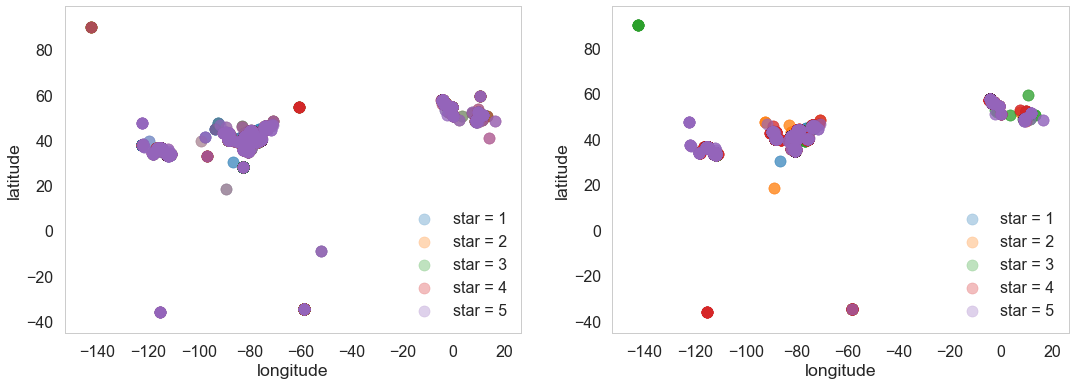

In [16]:
plt.figure(figsize=(18, 6))
for i in range(5):
    plt.subplot(1, 2, 1)
    plt.scatter(df_br[df_br['stars_x'] == i + 1]['longitude'], df_br[df_br['stars_x'] == i + 1]['latitude'], alpha = 0.3, label = 'star = ' + str(i + 1));
    plt.xlabel('longitude');
    plt.ylabel('latitude');
plt.legend();

for i in range(5):
    plt.subplot(1, 2, 2)
    plt.scatter(df_br[df_br['stars_y'] == i + 1]['longitude'], df_br[df_br['stars_y'] == i + 1]['latitude'], alpha = 0.3, label = 'star = ' + str(i + 1));
    plt.xlabel('longitude');
    plt.ylabel('latitude');
plt.legend();

# plt.subplot(1, 2, 2)
# plt.scatter(df_br['postal_code'], df_br['stars_x'])
# plt.xlabel('postal code')
# plt.ylabel('star')

In [17]:
# plt.figure(figsize=(20, 6))
# for i in range(5):
#     plt.subplot(1, 2, 1)
#     plt.scatter(df_br[df_br['stars_y'] == i + 1]['longitude'], df_br[df_br['stars_y'] == i + 1]['latitude'], alpha = 0.3, label = 'star = ' + str(i + 1));
#     plt.xlabel('longitude');
#     plt.ylabel('latitude');
# plt.legend();

# plt.subplot(1, 2, 2)
# plt.scatter(df_br['postal_code'], df_br['stars_y'])
# plt.xlabel('postal code')
# plt.ylabel('star')

Both individual stars and average stars seem to have some links with location (longitude and latitude, similar postal code refers to places close with each other as well). There are clustering effect for some locations, but the pattern is not clear. So simply including the numeric values of location variables in the later analysis is unreasonable.

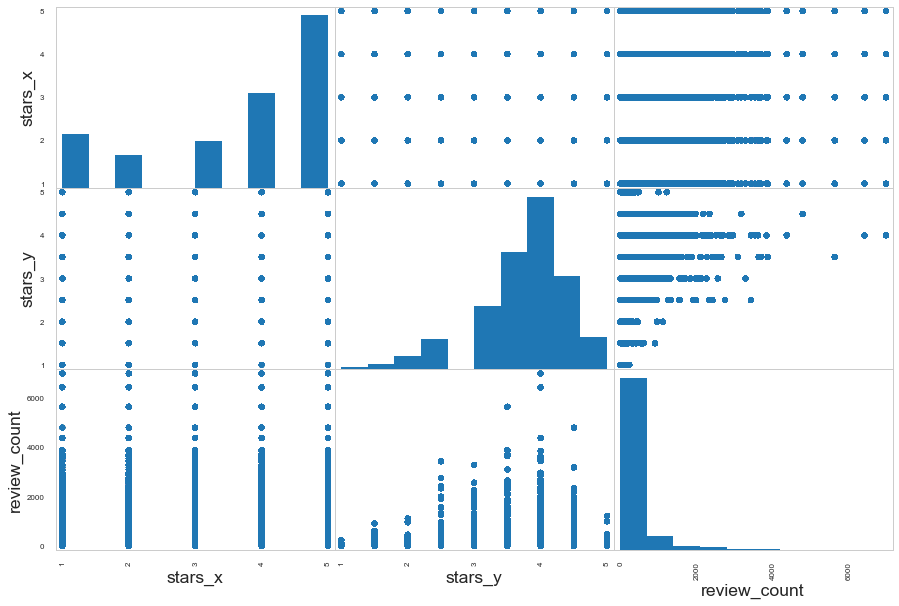

In [18]:
fig, ax = plt.subplots(1,1, figsize=(15,10));
axes = scatter_matrix(df_br[['stars_x', 'stars_y', 'review_count']], alpha=0.5, diagonal='hist', ax=ax);
plt.show();

We compare individual stars, restaurants' average stars and review count in the pair plot.

1. Stars given by single user has positive relationships with average stars of the restaurants

2. Higher average star is usually related to higher review count. Reason might be customers would choose high star restaurant to eat and comment. But there is no clear pattern between individual w.r.t. review_count.

In the following, we explore the relationships between average stars and different attributes of the restaurants.

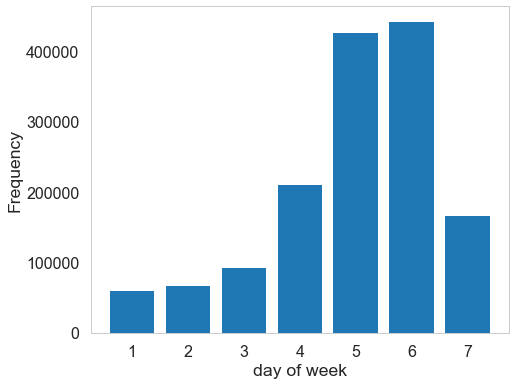

In [19]:
week = ['monday', 'tuesday', 'wednesday','thursday', 'friday', 'saturday', 'sunday']
count = []

for i in week:
    count.append(df_br.groupby(['attributes.BestNights.' + i]).size()[1]);

plt.figure(figsize=(7.5, 6))
plt.bar(range(1, 8), count);
plt.xlabel('day of week');
plt.ylabel('Frequency');

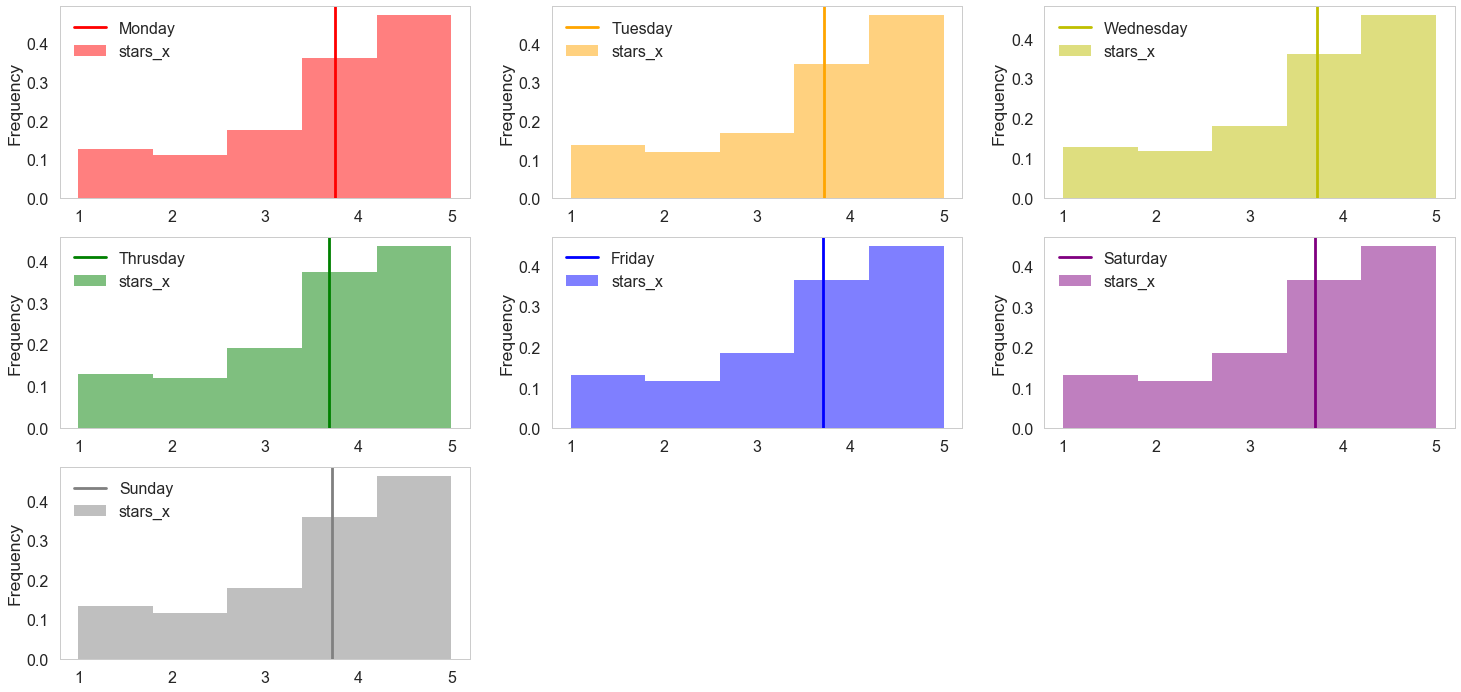

In [20]:
plt.figure(figsize=(25, 12))
plt.subplot(3, 3, 1)
df_br[df_br['attributes.BestNights.monday']==True]['stars_x'].plot.hist(alpha=0.5, bins = 5, color = 'r',normed=True)
plt.axvline(x=df_br[df_br['attributes.BestNights.monday']==True]['stars_x'].mean(), color='r', label='Monday')
plt.legend(loc='upper left');

plt.subplot(3, 3, 2)
df_br[df_br['attributes.BestNights.tuesday']==True]['stars_x'].plot.hist(alpha=0.5, bins=5, color = 'orange',normed=True)
plt.axvline(x=df_br[df_br['attributes.BestNights.tuesday']==True]['stars_x'].mean(), color='orange', label='Tuesday')
plt.legend(loc='upper left');

plt.subplot(3, 3, 3)
df_br[df_br['attributes.BestNights.wednesday']==True]['stars_x'].plot.hist(alpha=0.5, bins=5, color = 'y',normed=True)
plt.axvline(x=df_br[df_br['attributes.BestNights.wednesday']==True]['stars_x'].mean(), color='y', label='Wednesday')
plt.legend(loc='upper left');

plt.subplot(3, 3, 4)
df_br[df_br['attributes.BestNights.thursday']==True]['stars_x'].plot.hist(alpha=0.5, bins=5, color = 'g',normed=True)
plt.axvline(x=df_br[df_br['attributes.BestNights.thursday']==True]['stars_x'].mean(), color='g', label='Thrusday')
plt.legend(loc='upper left');

plt.subplot(3, 3, 5)
df_br[df_br['attributes.BestNights.friday']==True]['stars_x'].plot.hist(alpha=0.5, bins=5, color = 'b',normed=True)
plt.axvline(x=df_br[df_br['attributes.BestNights.friday']==True]['stars_x'].mean(), color='b', label='Friday')
plt.legend(loc='upper left');

plt.subplot(3, 3, 6)
df_br[df_br['attributes.BestNights.saturday']==True]['stars_x'].plot.hist(alpha=0.5, bins=5, color = 'purple',normed=True)
plt.axvline(x=df_br[df_br['attributes.BestNights.saturday']==True]['stars_x'].mean(), color='purple', label='Saturday')
plt.legend(loc='upper left');

plt.subplot(3, 3, 7)
df_br[df_br['attributes.BestNights.sunday']==True]['stars_x'].plot.hist(alpha=0.5, bins=5, color = 'grey',normed=True)
plt.axvline(x=df_br[df_br['attributes.BestNights.sunday']==True]['stars_x'].mean(), color='grey', label='Sunday')
plt.legend(loc='upper left');

Some day of week such as Friday and Saturday have higher average stars and higher reviews.

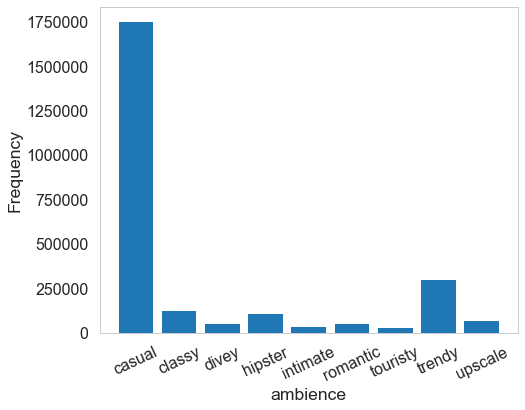

In [21]:
plt.figure(figsize=(7.5, 6))
count = []
ambience = ['casual', 'classy', 'divey', 'hipster', 'intimate', 'romantic', 'touristy', 'trendy', 'upscale']
for idx, i in enumerate(ambience):
    count.append(df_br.groupby(['attributes.Ambience.' + i]).size()[1])

plt.bar(range(len(ambience)), count);
plt.xticks(range(len(ambience)), ambience, rotation=25);
plt.ylabel("Frequency");
plt.xlabel("ambience");

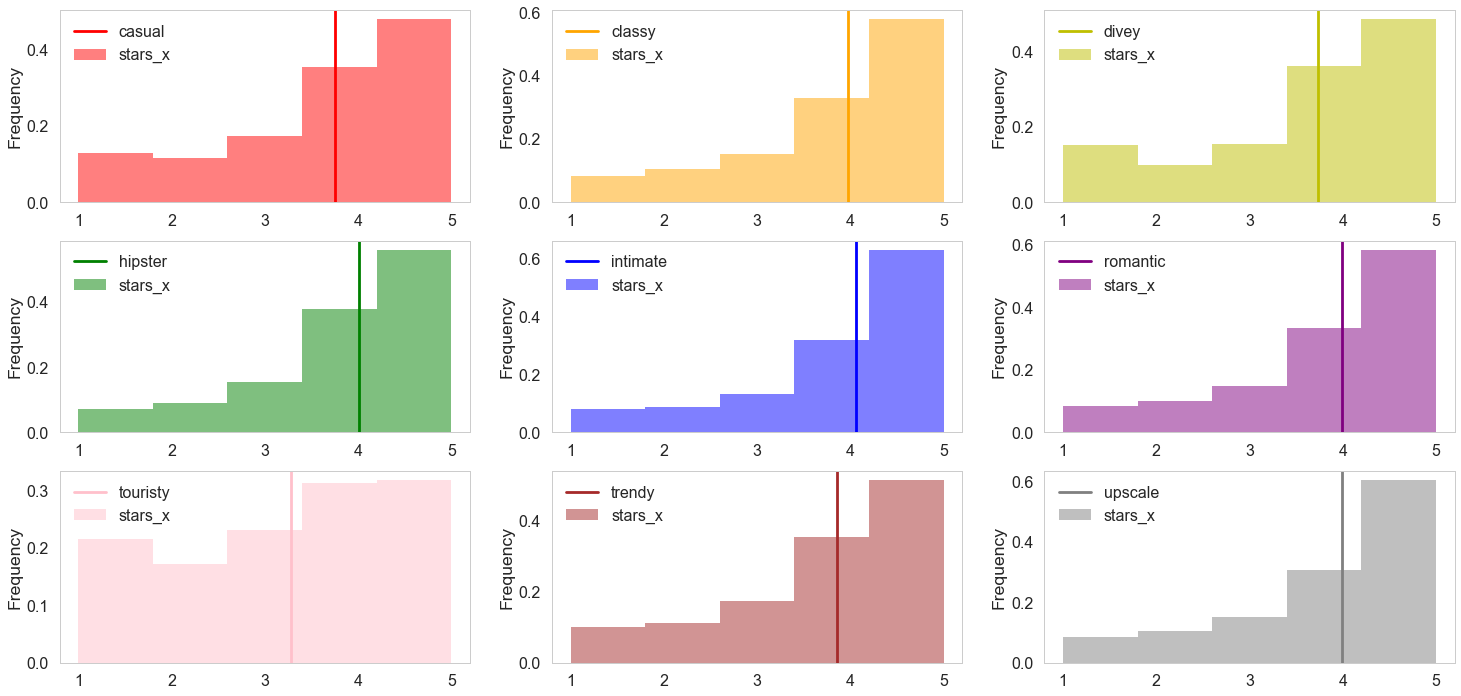

In [22]:
plt.figure(figsize=(25, 12))
plt.subplot(3, 3, 1)
df_br[df_br['attributes.Ambience.casual']==True]['stars_x'].plot.hist(alpha=0.5, bins = 5, color = 'r',normed=True)
plt.axvline(x=df_br[df_br['attributes.Ambience.casual']==True]['stars_x'].mean(), color='r', label='casual')
plt.legend(loc='upper left');

plt.subplot(3, 3, 2)
df_br[df_br['attributes.Ambience.classy']==True]['stars_x'].plot.hist(alpha=0.5, bins = 5, color = 'orange',normed=True)
plt.axvline(x=df_br[df_br['attributes.Ambience.classy']==True]['stars_x'].mean(), color='orange', label='classy')
plt.legend(loc='upper left');

plt.subplot(3, 3, 3)
df_br[df_br['attributes.Ambience.divey']==True]['stars_x'].plot.hist(alpha=0.5, bins = 5, color = 'y',normed=True)
plt.axvline(x=df_br[df_br['attributes.Ambience.divey']==True]['stars_x'].mean(), color='y', label='divey')
plt.legend(loc='upper left');

plt.subplot(3, 3, 4)
df_br[df_br['attributes.Ambience.hipster']==True]['stars_x'].plot.hist(alpha=0.5, bins = 5, color = 'g',normed=True)
plt.axvline(x=df_br[df_br['attributes.Ambience.hipster']==True]['stars_x'].mean(), color='g', label='hipster')
plt.legend(loc='upper left');

plt.subplot(3, 3, 5)
df_br[df_br['attributes.Ambience.intimate']==True]['stars_x'].plot.hist(alpha=0.5, bins = 5, color = 'b',normed=True)
plt.axvline(x=df_br[df_br['attributes.Ambience.intimate']==True]['stars_x'].mean(), color='b', label='intimate')
plt.legend(loc='upper left');

plt.subplot(3, 3, 6)
df_br[df_br['attributes.Ambience.romantic']==True]['stars_x'].plot.hist(alpha=0.5, bins = 5, color = 'purple',normed=True)
plt.axvline(x=df_br[df_br['attributes.Ambience.romantic']==True]['stars_x'].mean(), color='purple', label='romantic')
plt.legend(loc='upper left');

plt.subplot(3, 3, 7)
df_br[df_br['attributes.Ambience.touristy']==True]['stars_x'].plot.hist(alpha=0.5, bins = 5, color = 'pink',normed=True)
plt.axvline(x=df_br[df_br['attributes.Ambience.touristy']==True]['stars_x'].mean(), color='pink', label='touristy')
plt.legend(loc='upper left');

plt.subplot(3, 3, 8)
df_br[df_br['attributes.Ambience.trendy']==True]['stars_x'].plot.hist(alpha=0.5, bins = 5, color = 'brown',normed=True)
plt.axvline(x=df_br[df_br['attributes.Ambience.trendy']==True]['stars_x'].mean(), color='brown', label='trendy')
plt.legend(loc='upper left');

plt.subplot(3, 3, 9)
df_br[df_br['attributes.Ambience.upscale']==True]['stars_x'].plot.hist(alpha=0.5, bins = 5, color = 'grey',normed=True)
plt.axvline(x=df_br[df_br['attributes.Ambience.upscale']==True]['stars_x'].mean(), color='grey', label='upscale')
plt.legend(loc='upper left');

High level ambience might have fewer reviews but they also relate to higher stars. Most of the restaurants are casual and trendy, because high-end environment require more effort invested by restaurants.

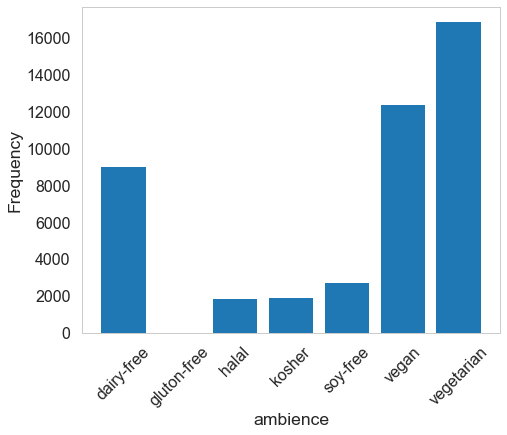

In [23]:
restrict = ['dairy-free', 'gluton-free', 'halal','kosher', 'soy-free', 'vegan', 'vegetarian']
count = []
plt.figure(figsize=(7.5, 6))
for idx, i in enumerate(restrict):
    if i == 'gluton-free':
        count.append(0)
    else:
        count.append(df_br.groupby(['attributes.DietaryRestrictions.' + i]).size()[1])

plt.bar(range(len(count)), count);
plt.xticks(range(len(count)), restrict, rotation=45);
plt.ylabel("Frequency");
plt.xlabel("ambience");

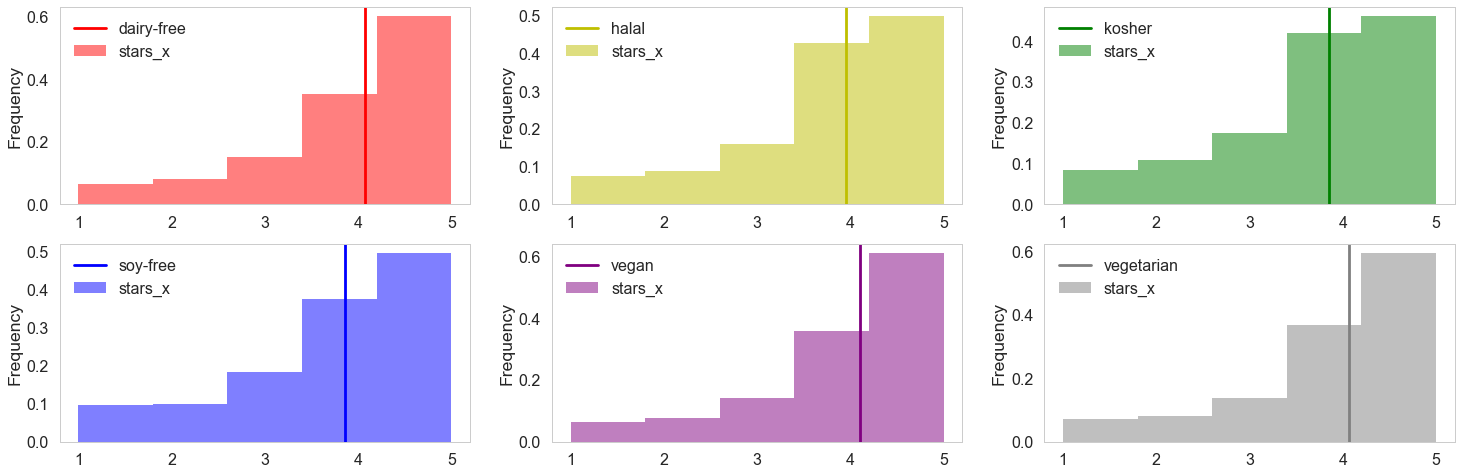

In [24]:
plt.figure(figsize=(25, 8))
plt.subplot(2, 3, 1)
df_br[df_br['attributes.DietaryRestrictions.dairy-free']==True]['stars_x'].plot.hist(alpha=0.5, bins = 5, color = 'r',normed=True)
plt.axvline(x=df_br[df_br['attributes.DietaryRestrictions.dairy-free']==True]['stars_x'].mean(), color='r', label='dairy-free')
plt.legend(loc='upper left');

# plt.subplot(2, 4, 2)
# df_br[df_br['attributes.DietaryRestrictions.gluten-free']==True]['stars_x'].plot.hist(alpha=0.5, bins=5, color = 'orange',normed=True)
# plt.axvline(x=df_br[df_br['attributes.DietaryRestrictions.gluten-free']==True]['stars_x'].mean(), color='orange', label='gluton-free')
# plt.legend(loc='upper left');

plt.subplot(2, 3, 2)
df_br[df_br['attributes.DietaryRestrictions.halal']==True]['stars_x'].plot.hist(alpha=0.5, bins=5, color = 'y',normed=True)
plt.axvline(x=df_br[df_br['attributes.DietaryRestrictions.halal']==True]['stars_x'].mean(), color='y', label='halal')
plt.legend(loc='upper left');

plt.subplot(2, 3, 3)
df_br[df_br['attributes.DietaryRestrictions.kosher']==True]['stars_x'].plot.hist(alpha=0.5, bins=5, color = 'g',normed=True)
plt.axvline(x=df_br[df_br['attributes.DietaryRestrictions.kosher']==True]['stars_x'].mean(), color='g', label='kosher')
plt.legend(loc='upper left');

plt.subplot(2, 3, 4)
df_br[df_br['attributes.DietaryRestrictions.soy-free']==True]['stars_x'].plot.hist(alpha=0.5, bins=5, color = 'b',normed=True)
plt.axvline(x=df_br[df_br['attributes.DietaryRestrictions.soy-free']==True]['stars_x'].mean(), color='b', label='soy-free')
plt.legend(loc='upper left');

plt.subplot(2, 3, 5)
df_br[df_br['attributes.DietaryRestrictions.vegan']==True]['stars_x'].plot.hist(alpha=0.5, bins=5, color = 'purple',normed=True)
plt.axvline(x=df_br[df_br['attributes.DietaryRestrictions.vegan']==True]['stars_x'].mean(), color='purple', label='vegan')
plt.legend(loc='upper left');

plt.subplot(2, 3, 6)
df_br[df_br['attributes.DietaryRestrictions.vegetarian']==True]['stars_x'].plot.hist(alpha=0.5, bins=5, color = 'grey',normed=True)
plt.axvline(x=df_br[df_br['attributes.DietaryRestrictions.vegetarian']==True]['stars_x'].mean(), color='grey', label='vegetarian')
plt.legend(loc='upper left');

The distributions for food restriction vary but star seem not to be related to these varialbes.

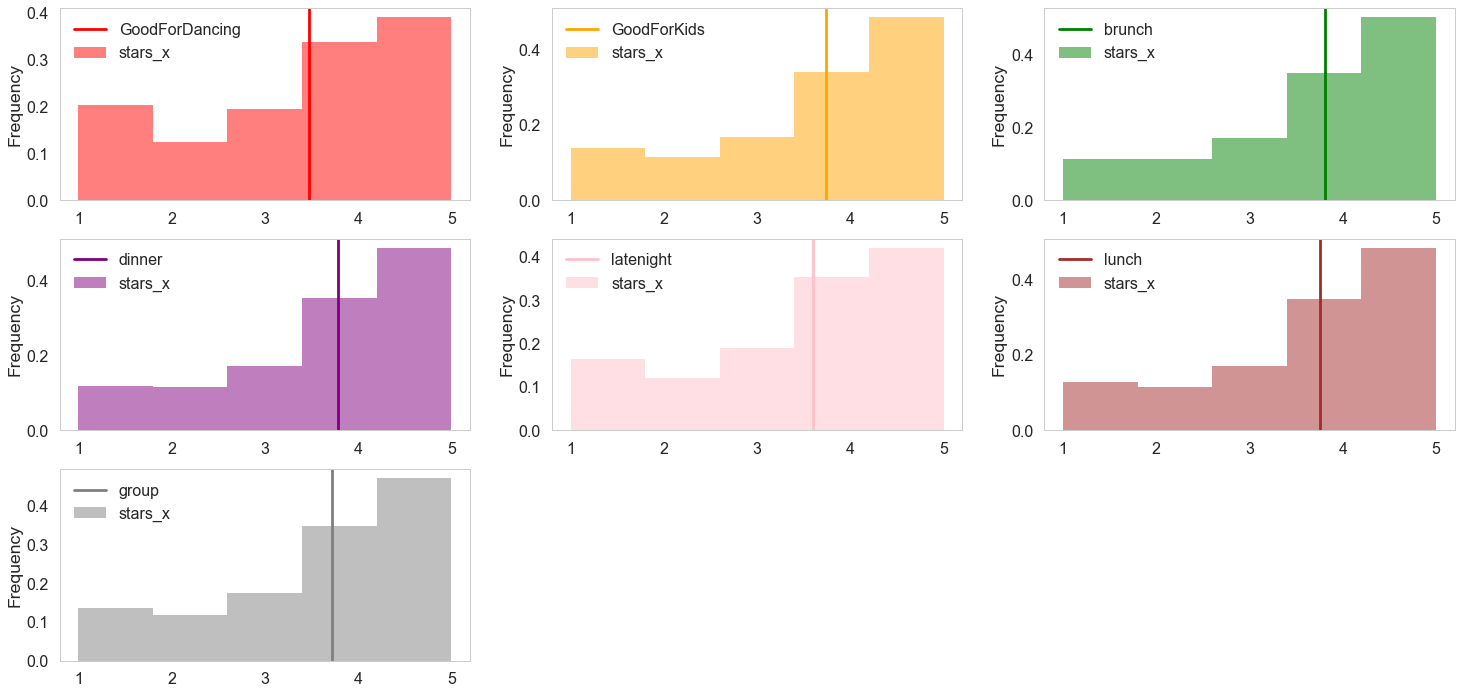

In [25]:
plt.figure(figsize=(25, 12))
plt.subplot(3, 3, 1)
df_br[df_br['attributes.GoodForDancing']==True]['stars_x'].plot.hist(alpha=0.5, bins = 5, color = 'r',normed=True)
plt.axvline(x=df_br[df_br['attributes.GoodForDancing']==True]['stars_x'].mean(), color='r', label='GoodForDancing')
plt.legend(loc='upper left');

plt.subplot(3, 3, 2)
df_br[df_br['attributes.GoodForKids']==True]['stars_x'].plot.hist(alpha=0.5, bins=5, color = 'orange',normed=True)
plt.axvline(x=df_br[df_br['attributes.GoodForKids']==True]['stars_x'].mean(), color='orange', label='GoodForKids')
plt.legend(loc='upper left');

# plt.subplot(3, 3, 3)
# df_br[df_br['attributes.GoodForMeal.breakfast']==True]['stars_x'].plot.hist(alpha=0.5, bins=5, color = 'y',normed=True)
# plt.axvline(x=df_br[df_br['attributes.GoodForMeal.breakfast']==True]['stars_x'].mean(), color='y', label='breakfast')
# plt.legend(loc='upper left');

plt.subplot(3, 3, 3)
df_br[df_br['attributes.GoodForMeal.brunch']==True]['stars_x'].plot.hist(alpha=0.5, bins=5, color = 'g',normed=True)
plt.axvline(x=df_br[df_br['attributes.GoodForMeal.brunch']==True]['stars_x'].mean(), color='g', label='brunch')
plt.legend(loc='upper left');

# plt.subplot(2, 5, 5)
# df_br[df_br['attributes.GoodForMeal.dessert']==True]['stars_x'].plot.hist(alpha=0.5, bins=5, color = 'b',normed=True)
# plt.axvline(x=df_br[df_br['attributes.GoodForMeal.dessert']==True]['stars_x'].mean(), color='b', label='dessert')
# plt.legend(loc='upper left');

plt.subplot(3, 3, 4)
df_br[df_br['attributes.GoodForMeal.dinner']==True]['stars_x'].plot.hist(alpha=0.5, bins=5, color = 'purple',normed=True)
plt.axvline(x=df_br[df_br['attributes.GoodForMeal.dinner']==True]['stars_x'].mean(), color='purple', label='dinner')
plt.legend(loc='upper left');

plt.subplot(3, 3, 5)
df_br[df_br['attributes.GoodForMeal.latenight']==True]['stars_x'].plot.hist(alpha=0.5, bins=5, color = 'pink',normed=True)
plt.axvline(x=df_br[df_br['attributes.GoodForMeal.latenight']==True]['stars_x'].mean(), color='pink', label='latenight')
plt.legend(loc='upper left');

plt.subplot(3, 3, 6)
df_br[df_br['attributes.GoodForMeal.lunch']==True]['stars_x'].plot.hist(alpha=0.5, bins=5, color = 'brown',normed=True)
plt.axvline(x=df_br[df_br['attributes.GoodForMeal.lunch']==True]['stars_x'].mean(), color='brown', label='lunch')
plt.legend(loc='upper left');

plt.subplot(3, 3, 7)
df_br[df_br['attributes.RestaurantsGoodForGroups']==True]['stars_x'].plot.hist(alpha=0.5, bins=5, color = 'grey',normed=True)
plt.axvline(x=df_br[df_br['attributes.RestaurantsGoodForGroups']==True]['stars_x'].mean(), color='grey', label='group')
plt.legend(loc='upper left');

Average score for restaurants good for dancing is relatively lower compared to other type. The reason might be they are usually indicated as noisy bar/pubs, which corresponds with our result in ambience.

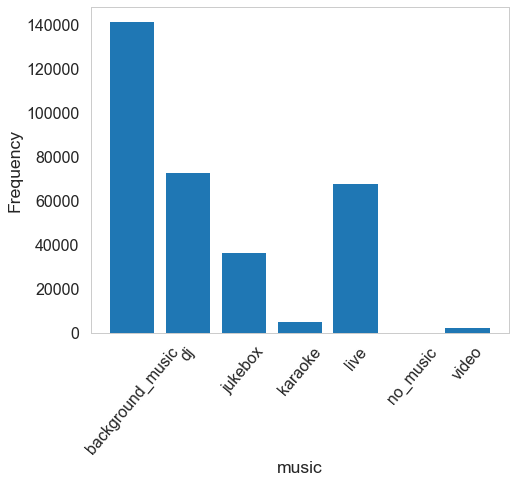

In [26]:
plt.figure(figsize=(7.5, 6))
music = ['background_music', 'dj', 'jukebox','karaoke', 'live', 'no_music', 'video']
count = []

for idx, i in enumerate(music):
    if i == 'no_music':
        count.append(0)
    else:
        count.append(df_br.groupby(['attributes.Music.' + i]).size()[1])

plt.bar(range(len(count)), count);
plt.xticks(range(len(count)), music, rotation=50);
plt.ylabel("Frequency");
plt.xlabel("music");

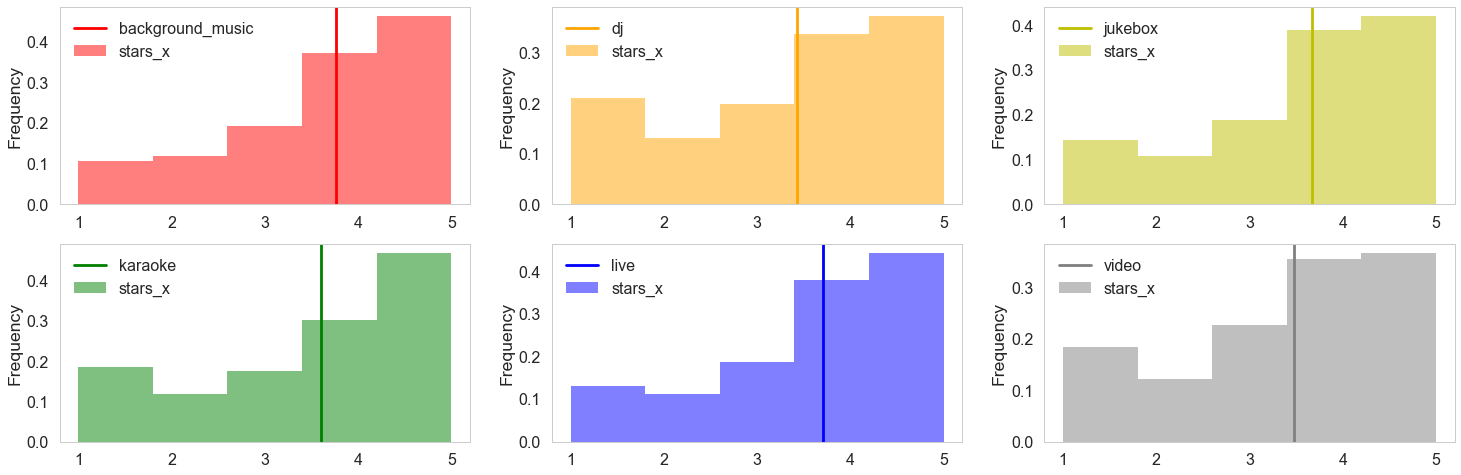

In [27]:
plt.figure(figsize=(25, 8))
plt.subplot(2, 3, 1)
df_br[df_br['attributes.Music.background_music']==True]['stars_x'].plot.hist(alpha=0.5, bins = 5, color = 'r',normed=True)
plt.axvline(x=df_br[df_br['attributes.Music.background_music']==True]['stars_x'].mean(), color='r', label='background_music')
plt.legend(loc='upper left');

plt.subplot(2, 3, 2)
df_br[df_br['attributes.Music.dj']==True]['stars_x'].plot.hist(alpha=0.5, bins=5, color = 'orange',normed=True)
plt.axvline(x=df_br[df_br['attributes.Music.dj']==True]['stars_x'].mean(), color='orange', label='dj')
plt.legend(loc='upper left');

plt.subplot(2, 3, 3)
df_br[df_br['attributes.Music.jukebox']==True]['stars_x'].plot.hist(alpha=0.5, bins=5, color = 'y',normed=True)
plt.axvline(x=df_br[df_br['attributes.Music.jukebox']==True]['stars_x'].mean(), color='y', label='jukebox')
plt.legend(loc='upper left');

plt.subplot(2, 3, 4)
df_br[df_br['attributes.Music.karaoke']==True]['stars_x'].plot.hist(alpha=0.5, bins=5, color = 'g',normed=True)
plt.axvline(x=df_br[df_br['attributes.Music.karaoke']==True]['stars_x'].mean(), color='g', label='karaoke')
plt.legend(loc='upper left');

plt.subplot(2, 3, 5)
df_br[df_br['attributes.Music.live']==True]['stars_x'].plot.hist(alpha=0.5, bins=5, color = 'b',normed=True)
plt.axvline(x=df_br[df_br['attributes.Music.live']==True]['stars_x'].mean(), color='b', label='live')
plt.legend(loc='upper left');

# plt.subplot(2, 3, 6)
# df_br[df_br['attributes.Music.no_music']==True]['stars_x'].plot.hist(alpha=0.5, bins=5, color = 'purple',normed=True)
# plt.axvline(x=df_br[df_br['attributes.Music.no_music']==True]['stars_x'].mean(), color='purple', label='no music')
# plt.legend(loc='upper left');

plt.subplot(2, 3, 6)
df_br[df_br['attributes.Music.video']==True]['stars_x'].plot.hist(alpha=0.5, bins=5, color = 'grey',normed=True)
plt.axvline(x=df_br[df_br['attributes.Music.video']==True]['stars_x'].mean(), color='grey', label='video')
plt.legend(loc='upper left');

Similar with results in "ambience" and "good for", upscale enviroment with live music have higher stars than those with viedo, dj or karaoke, which refers to noisy and crowded enviroment.

In the following, we select some interesting attributes that might indicate various stars from the corresponding boxplot.

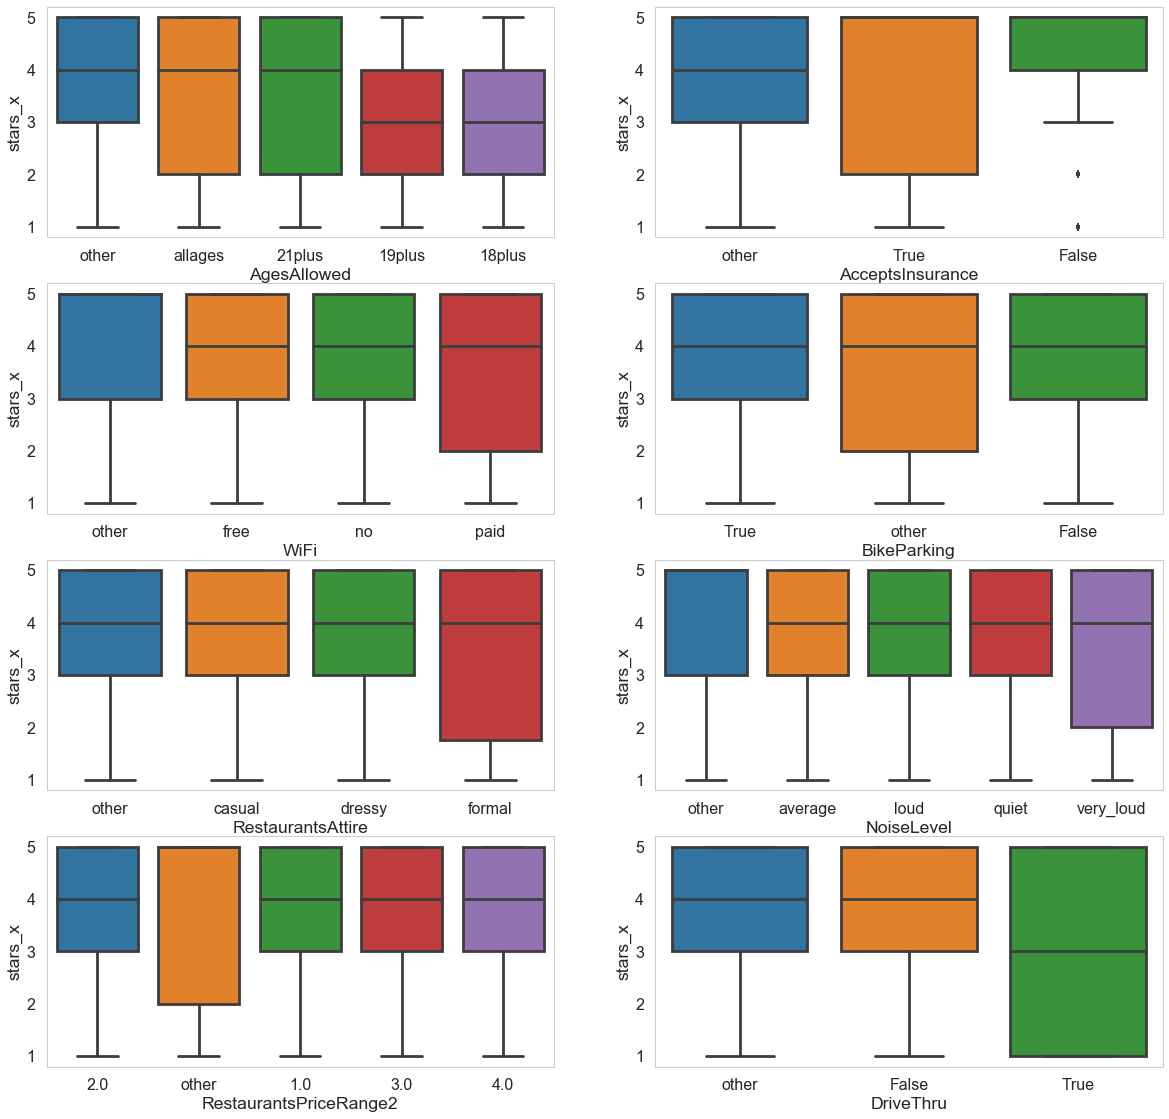

In [28]:
plt.figure(figsize=(20, 50))
plt.subplot(10, 2, 1)
df_br['AgesAllowed'] = df_br['attributes.AgesAllowed'].apply(lambda x: 'other' if pd.isnull(x) else x)
ax = sns.boxplot(x='AgesAllowed', y="stars_x", data=df_br)

plt.subplot(10, 2, 2)
df_br['AcceptsInsurance'] = df_br['attributes.AcceptsInsurance'].apply(lambda x: 'other' if pd.isnull(x) else x)
ax = sns.boxplot(x='AcceptsInsurance', y="stars_x", data=df_br)

plt.subplot(10, 2, 3)
df_br['WiFi'] = df_br['attributes.WiFi'].apply(lambda x: 'other' if pd.isnull(x) else x)
ax = sns.boxplot(x='WiFi', y="stars_x", data=df_br)

plt.subplot(10, 2, 4)
df_br['BikeParking'] = df_br['attributes.BikeParking'].apply(lambda x: 'other' if pd.isnull(x) else x)
ax = sns.boxplot(x='BikeParking', y="stars_x", data=df_br)

# plt.subplot(10, 2, 5)
# df_br['Smoking'] = df_br['attributes.Smoking'].apply(lambda x: 'other' if pd.isnull(x) else x)
# ax = sns.boxplot(x='Smoking', y="stars_x", data=df_br)

plt.subplot(10, 2, 5)
df_br['RestaurantsAttire'] = df_br['attributes.RestaurantsAttire'].apply(lambda x: 'other' if pd.isnull(x) else x)
ax = sns.boxplot(x='RestaurantsAttire', y="stars_x", data=df_br)

plt.subplot(10, 2, 6)
df_br['NoiseLevel'] = df_br['attributes.NoiseLevel'].apply(lambda x: 'other' if pd.isnull(x) else x)
ax = sns.boxplot(x='NoiseLevel', y="stars_x", data=df_br)

# plt.subplot(10, 2, 8)
# df_br['RestaurantsDelivery'] = df_br['attributes.RestaurantsDelivery'].apply(lambda x: 'other' if pd.isnull(x) else x)
# ax = sns.boxplot(x='RestaurantsDelivery', y="stars_x", data=df_br)

# plt.subplot(10, 2, 9)
# df_br['HasTV'] = df_br['attributes.HasTV'].apply(lambda x: 'other' if pd.isnull(x) else x)
# ax = sns.boxplot(x='HasTV', y="stars_x", data=df_br)

plt.subplot(10, 2, 7)
df_br['RestaurantsPriceRange2'] = df_br['attributes.RestaurantsPriceRange2'].apply(lambda x: 'other' if pd.isnull(x) else x)
ax = sns.boxplot(x='RestaurantsPriceRange2', y="stars_x", data=df_br)

plt.subplot(10, 2, 8)
df_br['DriveThru'] = df_br['attributes.DriveThru'].apply(lambda x: 'other' if pd.isnull(x) else x)
ax = sns.boxplot(x='DriveThru', y="stars_x", data=df_br)

# plt.subplot(10, 2, 12)
# df_br['HappyHour'] = df_br['attributes.HappyHour'].apply(lambda x: 'other' if pd.isnull(x) else x)
# ax = sns.boxplot(x='HappyHour', y="stars_x", data=df_br)

# plt.subplot(10, 2, 13)
# df_br['Open24Hours'] = df_br['attributes.Open24Hours'].apply(lambda x: 'other' if pd.isnull(x) else x)
# ax = sns.boxplot(x='Open24Hours', y="stars_x", data=df_br)

The pattern for stars distribution is different from now (open) and past (closed). Users are more critique (lower gap between five levels) at present.

## Exploration of User Table

In [29]:
# explore user table

## inner join user (dfu) & stars (datar)
df_ur = datar.merge(dfu, left_on="user_id", right_on="user_id")
# df_ur.head()

We analyze the users' information by merging user table and data_review table. We try to find relationships between star and users' properties of this merged table with shape (4166778, 24).

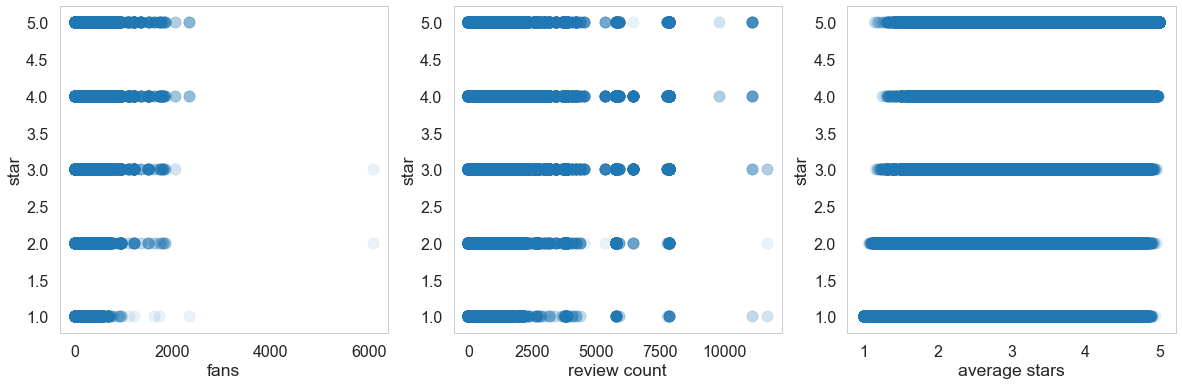

In [30]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
plt.scatter(df_ur['fans'], df_ur['stars'],alpha = 0.1);
plt.xlabel('fans')
plt.ylabel('star')

plt.subplot(1, 3, 2)
plt.scatter(df_ur['review_count'], df_ur['stars'],alpha = 0.1);
plt.xlabel('review count')
plt.ylabel('star')

plt.subplot(1, 3, 3)
plt.scatter(df_ur['average_stars'], df_ur['stars'],alpha = 0.1);
plt.xlabel('average stars')
plt.ylabel('star');

1. stars w.r.t. fans / review counts:
    Except for some outliners, users with more fans are more likely to give higher stars. The reason might be users with more followers are food bloggers, who is passionate about finding good restaurants. This phenonmen is less apparent for review counts.
    
2. stars w.r.t. users average_star:
    Users giving higher scores on average tend to have a positive review for each review.

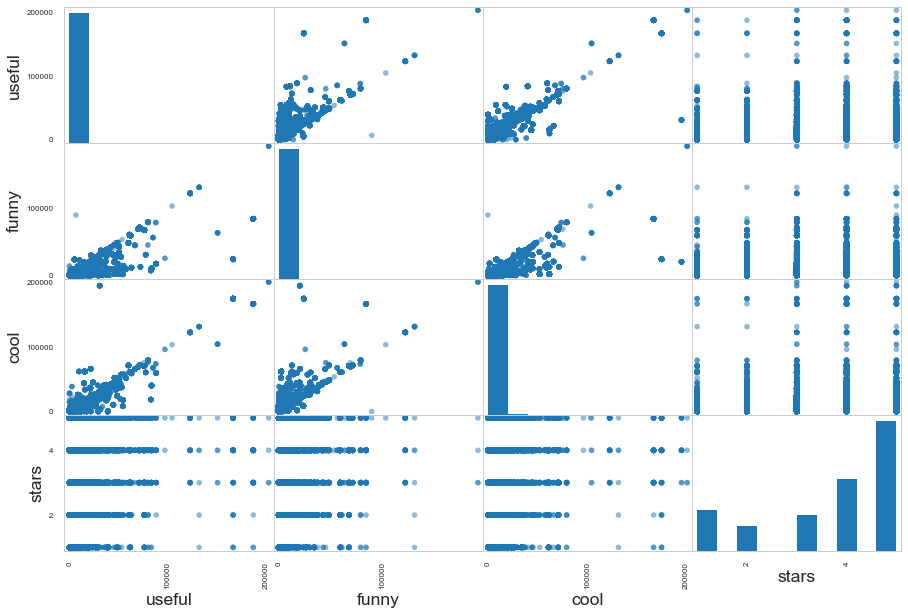

In [31]:
fig, ax = plt.subplots(1,1, figsize=(15,10))
axes = scatter_matrix(df_ur[['useful', 'funny', 'cool', 'stars']], alpha=0.5, diagonal='hist', ax=ax)
plt.show();

Higher score comments have more probability to be complimented as useful/funny/cool. Also, there are positive relationship between useful/funny/cool reviews. This may refers active users who prefer to comment on other's reviews.

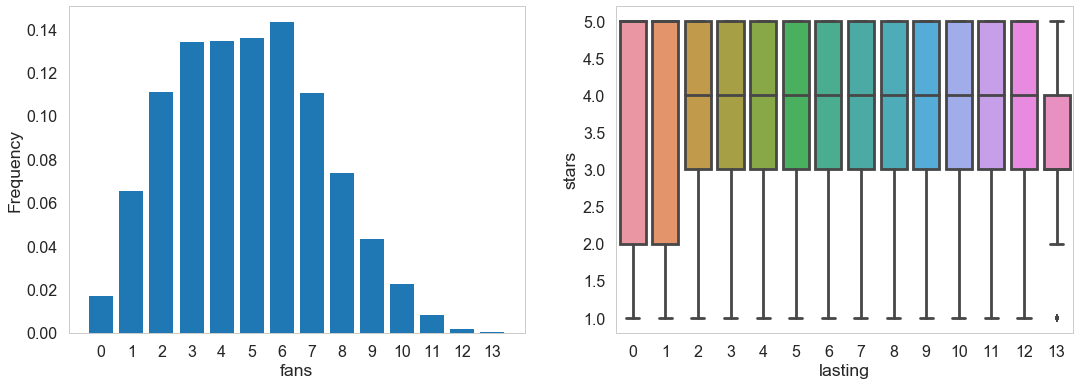

In [33]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
df_ur['lasting'] = df_ur['yelping_since'].apply(lambda x: 2017 - int(x[0:4]))
plot_discrete_hist(df_ur['lasting'].values, normalize=True);
plt.xlabel('fans');
plt.ylabel('Frequency');

plt.subplot(1, 2, 2)
sns.boxplot(x='lasting', y='stars', data=df_ur);

Most of users have utilized yelp for 2 - 7 years. Very old and loyalty yelp users tend to give higher and concentratated scores than new users (0-1 year). 

In [34]:
# fig, ax = plt.subplots(1,1, figsize=(30,30))
# axes = scatter_matrix(df_ur[['compliment_cool', 'compliment_cute', 'compliment_funny', 'compliment_hot', 'compliment_plain', 'stars']], alpha=0.5, diagonal='hist', ax=ax)
# plt.show()

We select some attributes of complement for analysis while others might have less obvious patterns with other variables. We could see there are positive relationships between these variables.

In [35]:
year_dict = {}
star_dict = {}
import ast

for idx, subset in df_ur.groupby('user_id'):
    if subset['elite'].any() != None:
        year_ls = ast.literal_eval(subset.iloc[0]['elite'])
        for year in year_ls:
            if year in year_dict:
                year_dict[year] += 1
                star_dict[year] += subset['stars'].mean()
            else:
                year_dict[year] = 1
                star_dict[year] = subset['stars'].mean()

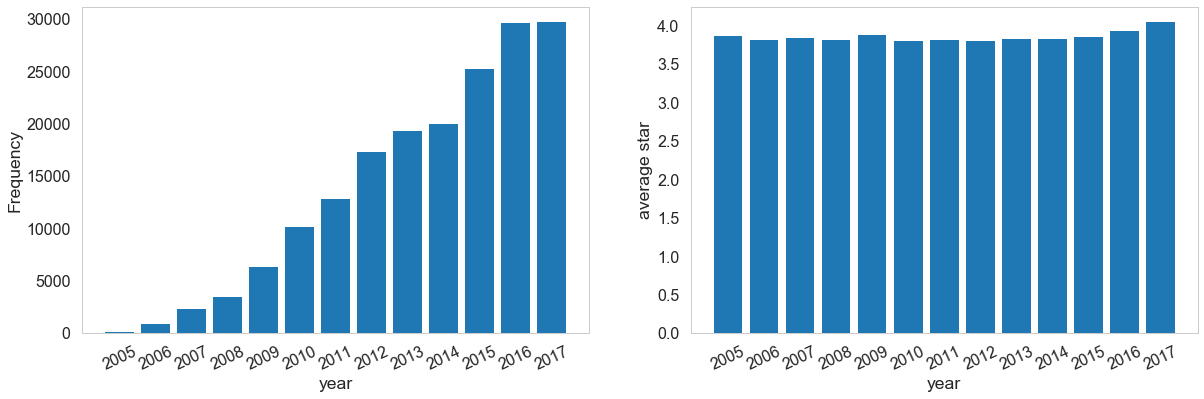

In [36]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.bar(range(len(year_dict)), sorted(year_dict.values()));
plt.xticks(range(len(year_dict)), sorted(year_dict.keys()), rotation=25);
plt.ylabel("Frequency");
plt.xlabel("year");

plt.subplot(1, 2, 2)
average_star = []

for idx, year in enumerate(year_dict):
    average_star.append(star_dict[year]/year_dict[year])
    
plt.bar(range(len(average_star)), average_star);
plt.xticks(range(len(average_star)), range(2005, 2018), rotation=25);
plt.ylabel("average star");
plt.xlabel("year");

The number of elite users is increasing, but the average scores (one user per count) given by them don't vary a lot.